In [11]:
#import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
#import data
tweet_data = pd.read_csv('Sign Off data.csv')

In [3]:
#remove a number of columns that are either not useful or not available to us when a tweet is newly written
tweet_data = tweet_data.drop(['Day of week','Trump Wrote it','Time','Storm Length','Cluster','Probability that Trump Wrote it','Text','DateTime','Date','Diff','Not Retweet * Not Trump Wrote it'],axis=1).dropna()

#create set of independent variables
X = tweet_data.drop('Sign off',axis=1)

#create set of class labels
y = tweet_data['Sign off']

In [4]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle = True, stratify = y)

In [5]:
#instantiate a non-optimized gradientboosted classifier model
clf = GradientBoostingClassifier()

#set up large parameter space to search for optimal hyperparameters
params = {'learning_rate': [0.1,0.05,0.01,.0075],
 'max_depth': [None,6,7,8,9,10,5,4,3,2],
 'loss' : ['deviance', 'exponential'],
 'max_features': ['sqrt','log2',.5,.6,.7,.99],
 'min_samples_split': [2,3,4,5,6],
 'subsample':[1,.9,.8,.7,.6,.5],
 'n_estimators': [1500,500],
 'n_iter_no_change': [10,5],
 'criterion' : ['friedman_mse'],
 'random_state': [0],
 'validation_fraction': [.15,.1,.05],
 'min_samples_leaf':[1,2,3]}

#random search parameter space for optimal hyperparameter values (takes a while)
clf = RandomizedSearchCV(clf, params,n_iter=45, cv=6, n_jobs = 4, verbose=1)
clf.fit(X_train,y_train)

#return optimal hyperparameter values
clf.best_params_

Fitting 6 folds for each of 45 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed: 18.2min finished


{'validation_fraction': 0.15,
 'subsample': 0.7,
 'random_state': 0,
 'n_iter_no_change': 10,
 'n_estimators': 1500,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 0.6,
 'max_depth': 8,
 'loss': 'deviance',
 'learning_rate': 0.0075,
 'criterion': 'friedman_mse'}

In [7]:
#instantiate tuned model
sign_off_model = GradientBoostingClassifier(**clf.best_params_) 

#train on train set
sign_off_model.fit(X_train,y_train)

#return accuracy of model on hold-out test set
print('Accuracy = {}'.format(sign_off_model.score(X_test,y_test)))

Accuracy = 0.6670751633986928


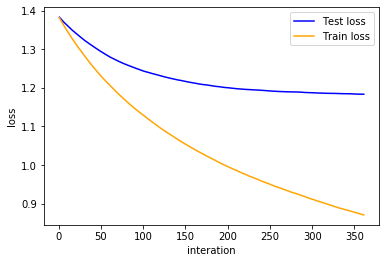

In [9]:
#plot test set error to ensure model convergence
test_deviance = np.zeros((clf.best_params_['n_estimators'],), dtype=np.float64)
train_deviance = np.zeros((clf.best_params_['n_estimators'],), dtype=np.float64)

#fill training and testing loss as a function of tree estimators
for i, y_pred in enumerate(sign_off_model.staged_decision_function(X_test)):
    test_deviance[i]  = sign_off_model.loss_(y_test, y_pred)
for i, y_pred in enumerate(sign_off_model.staged_decision_function(X_train)):
    train_deviance[i] = sign_off_model.loss_(y_train, y_pred)

#ignore losses of zero. These are spurious and exist because of early stopping
test_deviance = test_deviance[test_deviance.nonzero()]
train_deviance = train_deviance[train_deviance.nonzero()]

#plot the loss results
plt.figure(figsize=(8,5))
plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color='blue', label='Test loss')
plt.plot((np.arange(train_deviance.shape[0]) + 1)[::5], train_deviance[::5],
            '-', color='red', label='Train loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

The loss seems to converge

   Threshold  Accuracy  F1-score  Precision    Recall
0        0.3  0.615605  0.703248   0.560302  0.944115
1        0.4  0.658088  0.711876   0.599768  0.875529
2        0.5  0.667075  0.674130   0.638636  0.713802
3        0.6  0.653186  0.561240   0.720159  0.459780
4        0.7  0.600899  0.357659   0.800000  0.230313


(0, 1)

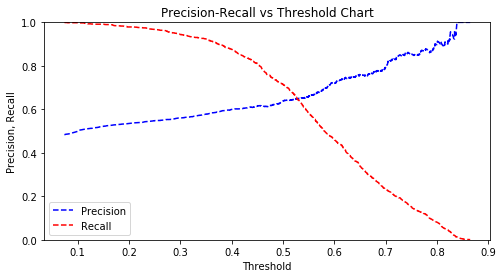

In [19]:
#define an accuracy metric
def acc(y_pred,y_true):
    return (y_pred==y_true).astype(int).mean()

#Find optimal threshold for classification

#model predictions and probability output for test set
y_pred  = sign_off_model.predict(X_test) 
y_probabilities = sign_off_model.predict_proba(X_test) 
precision, recall, thresholds = precision_recall_curve(y_test, y_probabilities[:, 1]) 

#see metrics for different thresholds
test_stats = np.zeros((5,5))
threshold_testing = [.3,.4,.5,.6,.7]
for n,threshold in enumerate(threshold_testing):
    test_stats[n,0] = threshold
    test_stats[n,1] = acc(sign_off_model.predict_proba(X_test)[:,1]>=threshold,y_test)
    test_stats[n,2] = metrics.f1_score(y_test,sign_off_model.predict_proba(X_test)[:,1]>=threshold)
    test_stats[n,3] = metrics.precision_score(y_test,sign_off_model.predict_proba(X_test)[:,1]>=threshold)
    test_stats[n,4] = metrics.recall_score(y_test,sign_off_model.predict_proba(X_test)[:,1]>=threshold)

test_statistics_df = pd.DataFrame(test_stats,columns=['Threshold','Accuracy','F1-score','Precision','Recall'])
print(test_statistics_df)

#plot precision and recall by threshold choice
plt.figure(figsize=(8,4))
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [22]:
#plot confusion matrix
pd.crosstab(y_test,  (sign_off_model.predict_proba(X_test)[:,1]>0.4).astype(int), rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,577,690,1267
1,147,1034,1181
All,724,1724,2448


As indicated above, the model is better at distinguishing sign_off = 0 than sign_off = 1. Choosing a slightly lower threshold than the default 0.5 gives a large boost in recall for a small decrease in precision.

Below is a series of graphs that are used in the medium article

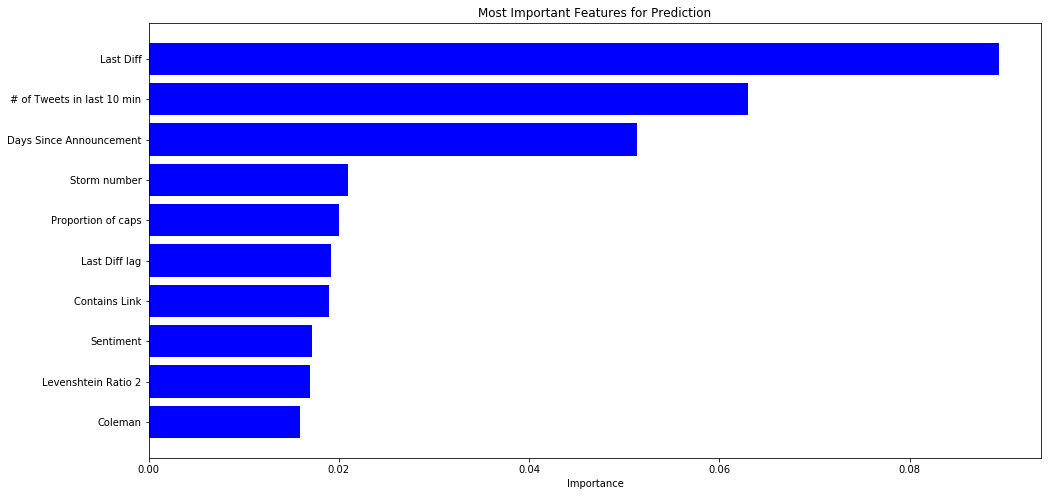

In [29]:
#list of tuples organized like (feature_name, feature_importance)
feat_importance = [(X.columns[n],x) for n,x in enumerate(pd.Series(sign_off_model.feature_importances_,index=X.columns))]

plt.figure(figsize=(16,8))

# most important features
features_most  = [x[0] for x in sorted(feat_importance, key = lambda x: x[1])[-10:]]
performance_most  = [x[1] for x in sorted(feat_importance, key = lambda x: x[1])[-10:]]

y_pos = np.arange(10)
plt.barh(y_pos, performance_most, align='center', color = 'blue')

plt.yticks(y_pos,features_most)
plt.xlabel('Importance')
plt.title('Most Important Features for Prediction')
#plt.savefig('most important features.png')

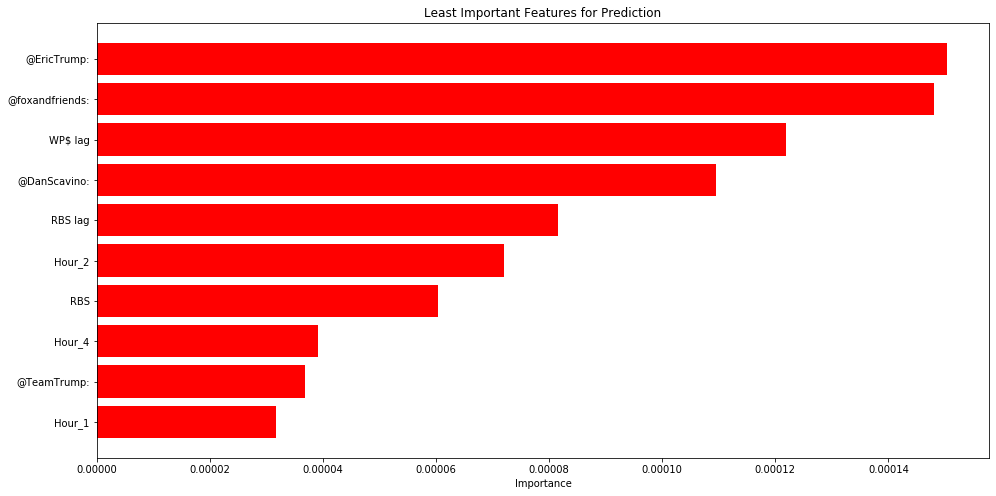

In [30]:
plt.figure(figsize=(16,8))

# most and least important features
features_least = [x[0] for x in sorted(feat_importance, key = lambda x: x[1])[10:20]]
performance_least = [x[1] for x in sorted(feat_importance, key = lambda x: x[1])[10:20]]

y_pos = np.arange(10)
plt.barh(y_pos, performance_least, align='center', color = 'red')

plt.yticks(y_pos,features_least)
plt.xlabel('Importance')
plt.title('Least Important Features for Prediction')
#plt.savefig('least important features.png')